# Used packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from zipfile import ZipFile
from google.colab import files
from matplotlib import pyplot as plt
#!pip install squarify
#import squarify
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error



import  scipy.sparse as ss
!pip install implicit
import implicit
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 144 kB/s 


/usr/local/lib/python3.8/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [ ]:
# If you don't want to download data from kaggle
files.upload() # here choose kaggle.json
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!kaggle datasets list -s h-and-m-personalized-fashion-recommendations

In [ ]:
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

100% 28.7G/28.7G [16:49<00:00, 39.6MB/s]
100% 28.7G/28.7G [16:49<00:00, 30.5MB/s]


In [ ]:
# Bad way as there are lots of images
#!unzip h-and-m-personalized-fashion-recommendations.zip -d data

In [ ]:
# Create a ZipFile Object and load sample.zip in it
with ZipFile('h-and-m-personalized-fashion-recommendations.zip', 'r') as zipObj:
   # Get a list of all archived file names from the zip
   listOfFileNames = zipObj.namelist()
   # Iterate over the file names
   for fileName in listOfFileNames:
       # Check filename ends with csv
       if fileName.endswith('.csv'):
           # Extract a single file from zip
           zipObj.extract(fileName)

In [ ]:
# Read data
articles = pd.read_csv("articles.csv")
customers = pd.read_csv("customers.csv")
transactions = pd.read_csv("transactions_train.csv") # or "new_trans.csv"

In [3]:
articles = pd.read_csv("articles.csv")


# Articles
contribution: Kristina

In [ ]:
 articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [ ]:
articles.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [ ]:
# Select the most interesting columns

articles = articles[['article_id', 'product_code', 'prod_name',
       'product_type_name', 'product_group_name', 'colour_group_name',
       'department_name', 'index_name', 'index_group_name', 'section_name']]

In [ ]:
articles.product_group_name.unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Underwear/nightwear', 'Shoes', 'Swimwear',
       'Garment Full body', 'Cosmetic', 'Interior textile', 'Bags',
       'Furniture', 'Garment and Shoe care', 'Fun', 'Stationery'],
      dtype=object)

In [ ]:
# Let's analyse what is the most diverse type of cloth in terms of number of items.
type_group = articles.groupby(['product_group_name'], as_index = False).count()
type_group = type_group.iloc[:,:2]
type_group.columns = ['categories', 'number_of_items']
type_group['number_of_items'].sum()
type_group['share_category, %'] = type_group['number_of_items']/type_group['number_of_items'].sum()*100
type_group.sort_values(by=['share_category, %'], ascending=False)

,categories,number_of_items,"share_category, %"
7,Garment Upper body,42741,40.496674
6,Garment Lower body,19812,18.771674
5,Garment Full body,13292,12.594038
0,Accessories,11158,10.572095
16,Underwear,5490,5.201721
12,Shoes,5283,5.005590
15,Swimwear,3127,2.962802
13,Socks & Tights,2442,2.313771
11,Nightwear,1899,1.799284
18,Unknown,121,0.114646


In [ ]:
type_group = type_group[type_group['number_of_items'] > 2000]
#type_group['scale'] = (type_group['number_of_items'] - min(type_group['number_of_items']))/min(type_group['number_of_items'])
type_group

,categories,number_of_items,"share_category, %"
0,Accessories,11158,10.572095
5,Garment Full body,13292,12.594038
6,Garment Lower body,19812,18.771674
7,Garment Upper body,42741,40.496674
12,Shoes,5283,5.005590
13,Socks & Tights,2442,2.313771
15,Swimwear,3127,2.962802
16,Underwear,5490,5.201721


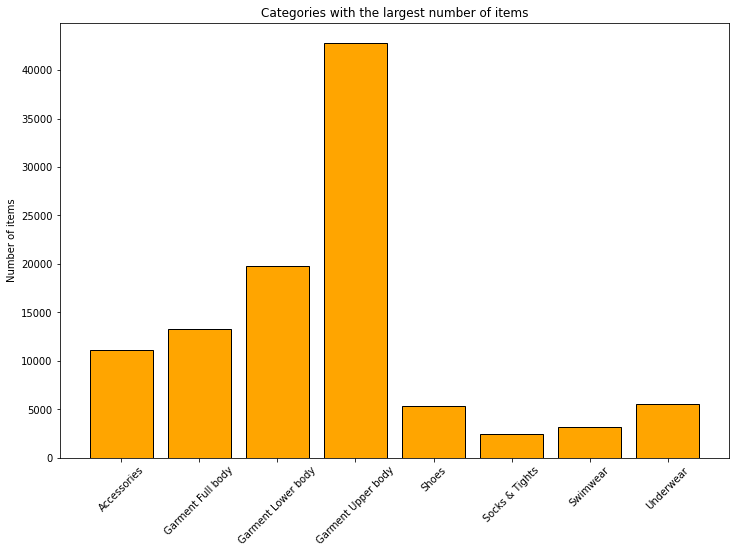

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(type_group['categories'], type_group['number_of_items'], color = "orange", edgecolor = "black")
plt.xticks(rotation = 45)
plt.title("Categories with the largest number of items")
plt.ylabel("Number of items")
plt.show()

Short conclusion: H&M sells 42741 items of **upper body** clothes, which is 40%  out of all selling items. It means that for this category **the diversity of items is the highest one.**
Top categories in terms of number of items: 
1. Garment Upper body	
2. Garment Lower body	
3. Garment Full body	

Tatyana's part

<BarContainer object of 7 artists>

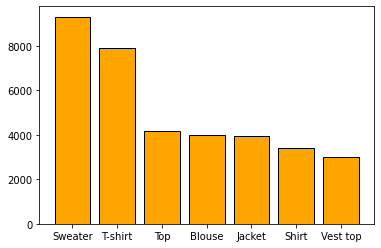

In [ ]:
# Now let's analyse what types of clothes is sold Top categories
# Garment Upper body 
articles_upper = articles.loc[articles['product_group_name'] == 'Garment Upper body']
type_upper = articles_upper.groupby(['product_type_name'], as_index = False).count().iloc[:,:2].sort_values(by=['article_id'], ascending=False)
type_upper.columns = ['Types', 'number_of_items']
plt.bar(type_upper.iloc[:7]['Types'], type_upper.iloc[:7]['number_of_items'], color = "orange", edgecolor = "black")


<BarContainer object of 5 artists>

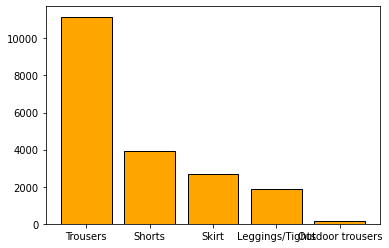

In [ ]:
# Garment Lower body 
articles_lower = articles.loc[articles['product_group_name'] == 'Garment Lower body']
type_lower = articles_lower.groupby(['product_type_name'], as_index = False).count().iloc[:,:2].sort_values(by=['article_id'], ascending=False)
type_lower.columns = ['Types', 'number_of_items']
plt.bar(type_lower.iloc[:7]['Types'], type_lower.iloc[:7]['number_of_items'], color = "orange", edgecolor = "black")


<BarContainer object of 5 artists>

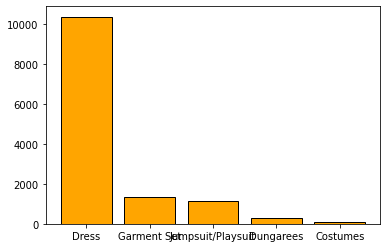

In [ ]:
#Garment Full body
articles_lower = articles.loc[articles['product_group_name'] == 'Garment Full body']
type_lower = articles_lower.groupby(['product_type_name'], as_index = False).count().iloc[:,:2].sort_values(by=['article_id'], ascending=False)
type_lower.columns = ['Types', 'number_of_items']
plt.bar(type_lower.iloc[:5]['Types'], type_lower.iloc[:5]['number_of_items'], color = "orange", edgecolor = "black")


# Customers
contribution: Kristina

In [ ]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


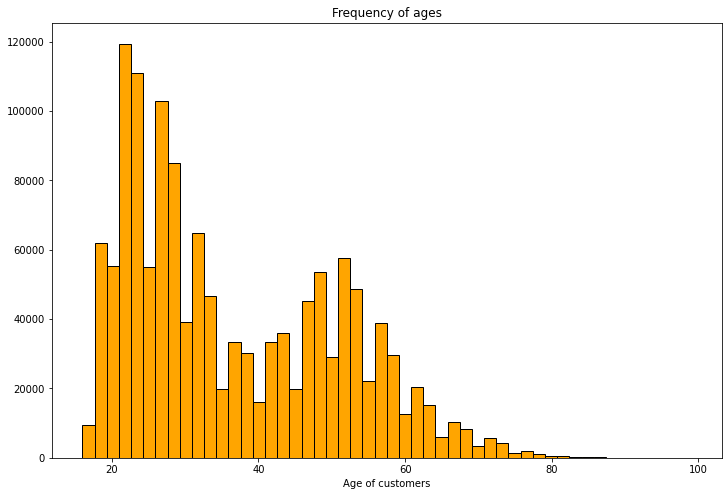

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(customers.age, edgecolor = 'black', color = 'orange', bins = 50);
plt.title("Frequency of ages")
plt.xlabel("Age of customers");

The histogram shows that the most nuber of purchases are made by people of 20-30 age years old

In [ ]:
member = customers.groupby(['club_member_status'], as_index = False).count()
y = customers.club_member_status.unique()

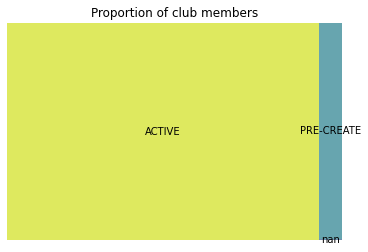

In [ ]:
squarify.plot(sizes = member.customer_id,
              label = y, alpha = 0.7)
plt.axis('off')
plt.title("Proportion of club members")
plt.show()

We have a large group of active club memebers. So, these types can have something like a recommendation system or special sales. Also it maybe mean that there is a significant part of regualar customers

In [ ]:
news = customers.groupby(['fashion_news_frequency'], as_index = False).count()
news = news[news['customer_id'] > 100]  # To avoid None that have 2 persons
y = news.fashion_news_frequency.unique()

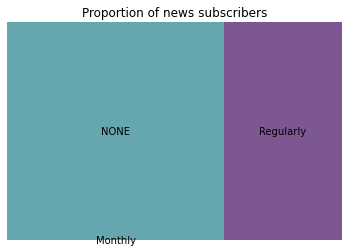

In [ ]:
squarify.plot(sizes = news.customer_id,
              label = y, alpha = 0.7)
plt.axis('off')
plt.title("Proportion of news subscribers")
plt.show()

Most part does not recieve recommendations from the cite and maybe potentially is not interested in recommendations

# Transactions
contribution: Kristina

In [ ]:
transactions.head(10)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
5,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001,0.016932,2
6,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221001,0.020322,2
7,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,688873012,0.030492,1
8,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,501323011,0.053373,1
9,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,598859003,0.045746,2


In [ ]:
transactions.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [ ]:
mean_price = transactions.groupby(['t_dat', 'customer_id'], as_index = False)['price'].mean()
mean_price

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(mean_price.price, edgecolor = 'black', color = 'orange', bins = 50, range = [0.0, 0.2]);
plt.title("Average price for purchase")
plt.xlabel("Price");  # Unfortunetly, there is no information about units

In [ ]:
mean_transactions = transactions.groupby(['t_dat', 'customer_id'], as_index = False)['article_id'].count()
mean_transactions.head(10)

,t_dat,customer_id,article_id
4540089,2019-09-07,69a9c5865987addc53e78e2eec1696da82da6ca94feff9...,1
4567472,2019-09-10,0b598764c77eeca6ef3434f032f4a37e6cd39c8567a704...,1
4567475,2019-09-10,0b5c3c30b5f894a7f5434de12bc7125da44329b27d86c8...,1
4567477,2019-09-10,0b6f638ebdc4ef23afda7b590cdb70fe0e67b2c495cf11...,1
4567479,2019-09-10,0b77cebd3408d6f42b9becfc96de4a5c0f969bad5c4122...,1
...,...,...,...
1869380,2019-02-16,94665b46e194622ccdbcadc0170f13a2f8ede1ff6d057d...,199
333665,2018-10-15,246734d8f4a4252fcd5c7aa525055a2804b9a6fb3d4210...,220
1489900,2019-01-13,62fd7d41b587c72a95c31eca5046019ce4e802853397ff...,221
1161741,2018-12-17,c2f0cdda2dc3042ccd9fcd8253fd8e368769840581e40a...,336


In [ ]:
# Average number of iteams, that a consumer buys
mean_transactions.article_id.mean()

On average, a customer buys 3-4 items

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(mean_transactions.article_id, edgecolor = 'black', color = 'orange', bins = 20, range = [0.0, 30]);
plt.xlabel("Number of purchases");
# Think how to cut the range of a histogram

In [ ]:
popular_items = transactions.groupby(['article_id'], as_index = False)['t_dat'].count()
top_items = popular_items.sort_values(['t_dat'], ascending = False)[:20]  # Top 20 items 
top_items = top_items.rename(columns = {"t_dat":"count"})

In [ ]:
result = pd.merge(top_items, articles, on = "article_id")
result  # We can just recommend customers to buy the most popular items

First of all we should prepare the data. We add some features from customers table to transactions_train data

In [ ]:
customers.columns

In [ ]:
customs = customers[['customer_id', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']]

In [ ]:
customs.club_member_status.unique()

In [ ]:
customs.fashion_news_frequency.unique()

In [ ]:
# We have some categories that should be noted as 'not defined'
# However, we have some different combinations for this category in 'fashion_news_frequency'
# And 'nan' in 'club_member_status'

customs.club_member_status = customs.club_member_status.fillna(0)
customs.club_member_status = customs.club_member_status.replace(0, "NOT_DEF")

In [ ]:
customs.fashion_news_frequency = customs.fashion_news_frequency.fillna(0)
customs.fashion_news_frequency = customs.fashion_news_frequency.replace(['None', 0], 'NONE')

In [ ]:
customs = pd.get_dummies(customs, columns = ['fashion_news_frequency', 'club_member_status'], drop_first = True)

In [ ]:
customs

In [ ]:
transactions.columns

In [ ]:
transactions.describe()

In [ ]:
transactions.sort_values("customer_id")
customs.sort_values("customer_id")

In [ ]:
#res = pd.concat([customs, transactions], axis = 1, keys = 'customer_id', join = 'outer')
res = pd.merge(transactions, customs, on=['customer_id'], how='inner')

In [ ]:
res.head()

We tried to model KNN. However, because of memory lack we cannot receive results
Also, it is not a good method to desribe recommendations as a predicted variable is not specified correctly


# Dataset preparation
cotribution: Kristina



To simplify our data (problems with model estimation after downloads of files). We decide to model only for the most active users. So, let's try to produce another set of users

In [ ]:
# Set the top of popular items
most_transactions = transactions.groupby(["article_id"], as_index = False)["customer_id"].count()
most_transactions = most_transactions.rename(columns={"customer_id":"num_transactions"})
most_transactions = most_transactions.sort_values("num_transactions", ascending = False)
most_transactions.head(10)

,article_id,num_transactions
53832,706016001,50287
53833,706016002,35043
1711,372860001,31718
24808,610776002,30199
70124,759871002,26329
3706,464297007,25025
1712,372860002,24458
24807,610776001,22451
2233,399223001,22236
53834,706016003,21241


In [ ]:
most_transactions = most_transactions[:200]
# reduce the number to have an opportunity to evaluate the model

In [ ]:
most_transactions

,article_id,num_transactions
53832,706016001,50287
53833,706016002,35043
1711,372860001,31718
24808,610776002,30199
70124,759871002,26329
...,...,...
33831,640021005,6899
95131,866383001,6831
23478,605690001,6734
38575,658298001,6731


In [ ]:
transactions = transactions[transactions["article_id"].isin(most_transactions.article_id)].reset_index(drop=True)

In [ ]:
print("The number of unique items in a reduced set: ", len(transactions['article_id'].unique()))

The number of unique items in a reduced set:  200


In [ ]:
# Top of cutomers
most_customers = transactions.groupby(["t_dat","customer_id"], as_index = False)["article_id"].count()
most_customers = most_customers.rename(columns={"article_id":"num_transactions"})
most_customers = most_customers.sort_values("num_transactions", ascending = False)
most_customers = most_customers[most_customers['num_transactions'] > 10]
# This allows to delete customers who buy less than 11 items

In [ ]:
transactions = transactions[transactions["customer_id"].isin(most_customers.customer_id)].reset_index(drop=True)

In [ ]:
print("The number of unique customers in a reduced set: ", len(transactions['customer_id'].unique()))

The number of unique customers in a reduced set:  1255


In [ ]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,150e3d09b926dceebb85dddaf506feb6cdbad3c7c8c5e0...,539723001,0.031051,2
1,2018-09-20,150e3d09b926dceebb85dddaf506feb6cdbad3c7c8c5e0...,539723001,0.030932,2
2,2018-09-20,150e3d09b926dceebb85dddaf506feb6cdbad3c7c8c5e0...,539723001,0.031051,2
3,2018-09-20,415a635c833eca2e0525fd673f76015545ad46591e189e...,539723001,0.031271,1
4,2018-09-20,415a635c833eca2e0525fd673f76015545ad46591e189e...,539723005,0.031271,1
...,...,...,...,...,...
30058,2020-09-22,8ba1d5230da686f7eef745d7739f81aa9a55fd6bd9bd65...,673677002,0.025407,2
30059,2020-09-22,8ba1d5230da686f7eef745d7739f81aa9a55fd6bd9bd65...,673677002,0.025407,2
30060,2020-09-22,8ba1d5230da686f7eef745d7739f81aa9a55fd6bd9bd65...,673677002,0.025407,2
30061,2020-09-22,8ba1d5230da686f7eef745d7739f81aa9a55fd6bd9bd65...,673677002,0.025407,2


In [ ]:
new_trans = transactions

In [ ]:
new_trans.to_csv("/content/new_trans.csv")
# Create a new file that is less than previous
# You can also find it in google disk

# Kmeans
contribution: Tatyana

In [ ]:
#Selecting the most interesting columns(features are incoded)
article_col = articles[['article_id', 'product_code','product_type_no', 'graphical_appearance_no', 'colour_group_code', 
                     'perceived_colour_value_id', 'perceived_colour_master_id', 'department_no', 'index_group_no',
                     'section_no', 'garment_group_no']] 

In [ ]:
from sklearn.preprocessing import LabelEncoder
customers_col = customers[['customer_id', 'club_member_status', 'fashion_news_frequency', 'age']]

# Creating a instance of label Encoder.
le = LabelEncoder()
# Using .fit_transform function to fit label
# encoder and return encoded label
label1 = le.fit_transform(customers_col['club_member_status'])
customers_col.drop("club_member_status", axis=1, inplace=True)

# Appending the array to our dataFrame
# with column name 'Purchased'
customers_col["club_member_status"] = label1



label2 = le.fit_transform(customers_col['fashion_news_frequency'])
customers_col.drop("fashion_news_frequency", axis=1, inplace=True)
customers_col["fashion_news_frequency"] = label2
customers_col




/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

,customer_id,age,club_member_status,fashion_news_frequency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,0,1
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,0,1
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,0,1
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,0,1
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,0,3
...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,24.0,0,1
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,21.0,0,1
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,21.0,0,3
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,18.0,0,3


In [ ]:
data1 = pd.merge(transactions,article_col, on = ['article_id'])
data2 = pd.merge(data1,customers_col, on = ['customer_id'])

In [ ]:
x = data2 [['product_code','product_type_no', 'graphical_appearance_no', 'colour_group_code', 
                     'perceived_colour_value_id', 'perceived_colour_master_id', 'index_group_no',
                     'section_no', 'garment_group_no', 'age', 'club_member_status','fashion_news_frequency' ]]

In [ ]:
xx = x.dropna()
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist 

rg = range(1, 20)
inertia = []
for k in rg: 
  kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)
  inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(rg, inertia, marker = 's'); 
plt.xlabel('$k$')
plt.ylabel('$J(C)$')


# Recommendation System. Preparation

On of the problem we have is that our data is not scaled. For example, movie database has ratings (stars 0-5 or 0-10). Thus, in this case we can range them. But for purchases we will constuct this mechanism by hands, based on frequency of purchases

In [ ]:
# a package that allows simply evaluate recommendation systems
!pip install turicreate
import turicreate as tc

To analyze what we should recommend to customers we should understand what kind of items they find most appropriate. We need to scale each item from 0 to 1. For this purpose we will produce several tables


1.   Define how many times an item was bought by a customer
2.   Define what items were bought by a customer
3.   Normalize these purchases



In [7]:
new_trans = pd.read_csv("new_trans.csv")
train = new_trans.groupby(["customer_id","article_id"])["t_dat"].count().reset_index()
train = train.rename(columns={"t_dat":"purchase_count"})
train

,customer_id,article_id,purchase_count
0,00750c6950d9a61ee44ed4520ef7262841a2e497956874...,158340001,21
1,00847ed06bb8bd9e10108eedc2757efd9d2871870314f1...,788261001,14
2,008fdadc3b5a58957554f466266bd9e601867b76b6a506...,399087014,1
3,008fdadc3b5a58957554f466266bd9e601867b76b6a506...,448509001,3
4,008fdadc3b5a58957554f466266bd9e601867b76b6a506...,568601006,1
...,...,...,...
8020,ffe26ec85b801a50021d5c411d97cabc511073099eddc0...,717490008,1
8021,ffe26ec85b801a50021d5c411d97cabc511073099eddc0...,719655001,5
8022,ffe8cceee64827679ba7535d4ad9427316610466f91418...,464297007,1
8023,ffe8cceee64827679ba7535d4ad9427316610466f91418...,733749001,1


In [ ]:
df_matrix = pd.pivot_table(train, values='purchase_count', index='customer_id', columns='article_id')
df_matrix.head(6)

article_id,111586001,111593001,200182001,234432001,240561001,244267029,249136020,249136022,251510001,297067002,...,691208001,692216003,692216005,692454002,696447003,699366001,700819006,702624001,708806001,717341001
customer_id,,,,,,,,,,,,,,,,,,,,,
000aa7f0dc06cd7174389e76c9e132a67860c5f65f970699daccc14425ac31a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN
029ceb992cb63df03c109790046e3fdebfce0b63c968823dd461b7f18ecc6b30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN
02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7ddbe7ac747ce4a6666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04050a0433c9050f619b3b54ac4b63c14a2d8b5afe121e63f04cfa739eb7eac7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
06bb67b780840ca01a98558e414d50f643d7870b9c78c0f5e82674a9db500e88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
077641946a092614f6da9c0ab14ce034907c4e168bd73ae680f423a11c20bf71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
df_matrix_norm.head(6)

article_id,111586001,111593001,200182001,234432001,240561001,244267029,249136020,249136022,251510001,297067002,...,691208001,692216003,692216005,692454002,696447003,699366001,700819006,702624001,708806001,717341001
customer_id,,,,,,,,,,,,,,,,,,,,,
000aa7f0dc06cd7174389e76c9e132a67860c5f65f970699daccc14425ac31a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
029ceb992cb63df03c109790046e3fdebfce0b63c968823dd461b7f18ecc6b30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7ddbe7ac747ce4a6666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04050a0433c9050f619b3b54ac4b63c14a2d8b5afe121e63f04cfa739eb7eac7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06bb67b780840ca01a98558e414d50f643d7870b9c78c0f5e82674a9db500e88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
077641946a092614f6da9c0ab14ce034907c4e168bd73ae680f423a11c20bf71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
d = df_matrix_norm.reset_index()
d.index.names = ['scaled_purchase_freq']
data_norm = pd.melt(d, id_vars=['customer_id'], value_name='scaled_purchase_freq').dropna()
data_norm

,customer_id,article_id,scaled_purchase_freq
1035,10dd9d402c8a3e406d7c451bd7941ca288e5a3284ec264...,467302100,0.0
1045,1b3b62857f0142096da649d2fc0ff045a0dd8c0ee76b45...,467302100,1.0
1832,0ae14ec796c207d313ae1bcc4a4691ef1d89a97b3ffdc6...,547747001,1.0
1839,14db47a2fbda1a661492073741feae346a12c1b1b34a54...,547747001,0.0
5704,06bb67b780840ca01a98558e414d50f643d7870b9c78c0...,639845009,1.0
5705,077641946a092614f6da9c0ab14ce034907c4e168bd73a...,639845009,0.0
7167,19c00929cebf971c736077c43ffb07d32f35fa024d8d08...,667491011,0.0
7174,1f115c3a14c8434167d789719457b5cc9f6d1cc2bccd06...,667491011,1.0
7279,06bb67b780840ca01a98558e414d50f643d7870b9c78c0...,667999004,0.0
7280,077641946a092614f6da9c0ab14ce034907c4e168bd73a...,667999004,0.0


### Split the data

In [ ]:
# We will use two data splits and train according to these modifications
train, test = train_test_split(train, test_size = .2)
train_data = tc.SFrame(train)
test_data = tc.SFrame(test)

train_norm, test_norm = train_test_split(data_norm, test_size = .2)
train_data_norm = tc.SFrame(train_norm)
test_data_norm = tc.SFrame(test_norm)

### Baseline Model (the same recommendation for all)

In [ ]:
# First one is to use "purchase_count"
# So, we will analyze what is the most popular item among customers

# variables to define field names
user_id = 'customer_id'
item_id = 'article_id'
target = 'purchase_count'
users_to_recommend = list(train[user_id])
n_rec = 12 # number of items to recommend according to 'sample_submission' file
n_display = 30 

In [ ]:
popularity_model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)

Preparing data set.

Data has 6420 observations with 1211 users and 200 items.

Data prepared in: 0.023626s

6420 observations to process; with 200 unique items.

In [ ]:
# Second one is about normalized data

target = 'scaled_purchase_freq'
pop_norm_model = tc.popularity_recommender.create(train_data_norm, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)

###Results

In [ ]:
popularity_recomm = popularity_model.recommend(users=users_to_recommend, k=n_rec)
popularity_recomm.print_rows(n_display)

According to results of this model we can recommend the most popular (most freaquently bought) items among all consumers 

In [ ]:
articles[(articles["article_id" ] == 507909003) | (articles["article_id" ] == 399087014) | (articles["article_id" ] == 685813001)  | (articles["article_id" ] == 561445005)]

One of the disadvantage of this method is that we do not personalize our recommendations. So, items are the same for all customers. Second is that according to our data cuts we throw away a lot of observations. However, it is the model with simpliest equations and our baseline

In [ ]:
regularization_recomm = pop_norm_model.recommend(users=users_to_recommend, k=n_rec)
regularization_recomm.print_rows(n_display)

The results are again the same for all customers. But we have different recommendations, because in the case of normalization we do not take into account the frequency of purchases. 

In purchase_count the most popular items more probably are from customers who are the most active. In scaled_purchase_freq we have scale this situaiton and just compare the normalize score

In [ ]:
articles[(articles["article_id" ] == 573085043) | (articles["article_id" ] == 783346018) | (articles["article_id" ] == 655784001)  | (articles["article_id" ] == 866383001)]

This kind of modelling doesn't imply the machine learning construction. We just use in recommendations the most popular items

# Collaborative Filtering Model


The main idea of collaborative filtering is to construct recommendations based on the 'closeness' of items. So, if someone buys item 1 that is closed to item 2, then we can advice item 2

To realize this idea we will construct the similarity matrix of items (according to cosine similarity). 

Then we will predict the probability that a customer will buy this recommended product

In [ ]:
# Again start from the purchase count
target = 'purchase_count'
count_pears = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
        
count_recom = count_pears.recommend(users=users_to_recommend, k=n_rec)
count_recom.print_rows(n_display)

I have alsotriedd to use pearson similarity. But the results are not so heterogenious and all users have nearly the same recommendations

In [ ]:
# And then take a look on the normalized data
target = 'scaled_purchase_freq'
count_pears_norm = tc.item_similarity_recommender.create(train_data_norm, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
        
recom = count_pears_norm.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

### Model Evaluation

We will use
- RMSE
- Precision
- Recall

In [ ]:
models = [popularity_model, count_pears]
names = ["Baseline Purchase count model", "Filttering model with Purchase count"]

In [ ]:
eval_counts = tc.recommender.util.compare_models(test_data, models, model_names=names)

PROGRESS: Evaluate model Baseline Purchase count model

Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.014084507042253527 | 0.013380281690140848 |
|   2    | 0.009154929577464787 | 0.015375586854460095 |
|   3    | 0.01032863849765258  | 0.023591549295774655 |
|   4    | 0.01161971830985916  | 0.03368544600938968  |
|   5    | 0.010704225352112684 | 0.03787726358148895  |
|   6    | 0.011737089201877937 | 0.04989604292421196  |
|   7    | 0.012072434607645878 | 0.05963782696177062  |
|   8    | 0.011971830985915493 | 0.06660965794768611  |
|   9    | 0.011424100156494517 | 0.07165660630449364  |
|   10   | 0.010563380281690144 | 0.07376928236083166  |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 5.001762022614471

Per User RMSE (best)
+-----------------

In [ ]:
models = [pop_norm_model, count_pears_norm]
names = ["Baseline Purchase normalization model", "Filttering model with Purchase normalization"]

In [ ]:
eval_counts = tc.recommender.util.compare_models(test_data_norm, models, model_names=names)

PROGRESS: Evaluate model Baseline Purchase normalization model

Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    | 0.0025348542458808617 | 0.0016899028305872414 |
|   2    |  0.008871989860583018 |  0.009442332065906212 |
|   3    |  0.008449514152936207 |  0.012970004224757083 |
|   4    | 0.0076045627376425855 |  0.01438529784537389  |
|   5    |  0.008111533586818763 |  0.01854668356569497  |
|   6    |  0.008027038445289403 |  0.02072243346007605  |
|   7    |  0.009053050878145941 |  0.02877059569074778  |
|   8    |  0.009980988593155894 |  0.036375158428390356 |
|   9    |  0.009857766511758896 |  0.040536544148711454 |
|   10   |  0.009505703422053225 |   0.0456062526404732  |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.22101851442647

Per 

According to RMSE we should choose the last evaluated model: normalized purchases according to cosine similarity. However, we have very bad precision and recall

### Prediction

In [ ]:
users_to_recommend = list(customers[user_id])
n_rec = 12

final_model = tc.item_similarity_recommender.create(tc.SFrame(data_norm), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='scaled_purchase_freq', 
                                            similarity_type='cosine')

recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

In [ ]:
df_rec = recom.to_dataframe()
df_rec.head()

In [ ]:
df_rec['recommend_item'] = df_rec.groupby(['customer_id'])['article_id'].transform(lambda x: '\n'.join(x.astype(str)))
df_output = df_rec[['customer_id', 'recommend_item']].drop_duplicates().sort_values('customer_id').set_index('customer_id')

Colaborative filtering is only one of the possible methods to recommend items. That actually doesn't base on machine learning algoritms. Just similarity of items or customers that we can calculate using Pearson or cosine correlation. In the next section we will analyze machine learning algorithm. But we can use collaborative filtering to complete our model

# Collaborative Filtering with KNN

In this section we will try to improve our model using KNN method to cluster similar users and predict their choices according to their 'closeness'

In [ ]:
# df_martix
df_KNN = pd.pivot_table(train, index='article_id', columns='customer_id', values='purchase_count').fillna(0)
matrix = csr_matrix(df_KNN.values)

In [ ]:
df_KNN

customer_id,00750c6950d9a61ee44ed4520ef7262841a2e497956874e39136526163f34524,00847ed06bb8bd9e10108eedc2757efd9d2871870314f1574d2ee23c342d1583,008fdadc3b5a58957554f466266bd9e601867b76b6a5067c462331d2807c1e3f,009a108ccf2356ced0561494ed3ef3597f7f75e1150c58bc63e45c2059cdaf16,009db236b68cde5b1005d66332f96d86d075e57fe6c3c9867bb4374a851cfac0,00f3cf84e96a1c17c0bf0806926c6d8b6b024c6d43a8545e3c9c9fea6a0ed37b,0101784de0f962f677dc66e5cd1a5905da2e9c2ce28db0d8ba8fd4676043e6fe,0133f98cb88f25dce00672600f11a704c681ba6487e21df5e929eb579d9c766c,01469ad3cc669009d1f710786f32fcd3fcf66373e78dbc2436f6e82ca1c137b2,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7347e450b550caf1f67,...,ff0709a27864e67ae3eaef1336da05d0f93a742a9f0e012eb57b16a3cb95a648,ff0bcafb2681bcd886a1f2ebc7e36c25c42cd2baeb0c59f0893432270bd6970d,ff2ecfb011989cf64d40900696397b2c14836fb01a34f16ca967e3b19ab3bc74,ff47fda9c9f5b0068650b3e9be9718c8b51a616b1c206a57ad9791130d555cfd,ff5d4ca84e16a2b9bd89ed4e049db526ff132dea9348ff30de3a485226a5f3ac,ff95fd793d6cfbbac2ce3d7f850a0f7d4270dbd4fb13503d2c4eac87527a5e72,ffc31d302bcfd0f312ba65cbd0472125a47cb3c6d6272c01fd4e6dc74abc29e3,ffc66f427202c975f39e9127ddb597ccbfc818c474a779f66e5d0b1fb4f9c7c3,ffe26ec85b801a50021d5c411d97cabc511073099eddc0467f9db80087a8a00e,ffe8cceee64827679ba7535d4ad9427316610466f91418d3ee4c16a42c4764c0
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
108775044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111586001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111593001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156231001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806388003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
841383002,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
841383003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
index = np.random.choice(df_KNN.shape[0])
dist, ind = model_knn.kneighbors(df_KNN.iloc[index,:].values.reshape(1,-1), 
                                 n_neighbors=4)

for i in range(0, len(dist.flatten())):
  if i == 0:
    print('Recommendation for {0}:' .format(df_KNN.index[index]))
  else:
    print('{0}: {1}, with distance of {2}:' .format(i, df_KNN.index[ind.flatten()[i]], dist.flatten()[i]))

Recommendation for 600886011:
1: 564786001, with distance of 0.7234817505183084:
2: 571706001, with distance of 0.7813194891679411:
3: 684209004, with distance of 0.8070338189982942:


In [ ]:
data = []
for i in range(0, len(dist.flatten())):
    data.append(articles[articles["article_id"] == df_KNN.index[ind.flatten()[i]]])
result = pd.concat(data)
result

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
22929,600886011,600886,Timeless Highwaist,59,Swimwear bottom,Swimwear,1010026,Other structure,9,Black,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Fully lined, waist-high bikini bottoms with wi..."
14931,564786001,564786,KARIN sports bra,306,Bra,Underwear,1010016,Solid,9,Black,...,Ladies Sport Bras,S,Sport,26,Sport,5,Ladies H&M Sport,1005,Jersey Fancy,Sports bra in fast-drying functional fabric wi...
16853,571706001,571706,Timeless High Rise Hipster,59,Swimwear bottom,Swimwear,1010016,Solid,9,Black,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,Fully lined bikini bottoms with a high waist a...
45791,684209004,684209,Simple as That Triangle Top,298,Bikini top,Swimwear,1010026,Other structure,9,Black,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Lined, non-wired, triangle bikini top with a w..."


According to this mechanism we can recommend most reliable items to his/her purchase

# Collaborative Filtering with Matrix Factorization


## ALS with correlation

In [8]:
df_mf = pd.pivot_table(train, values='purchase_count', index='customer_id', columns='article_id').fillna(0)


In [ ]:
df_mf.shape

(25, 347)

In [9]:
X = df_mf.values.T

In [ ]:
X.shape

(347, 25)

In [10]:
# Implement SVD method for matrix factorization
# Should choose the number of latent variables
svd = TruncatedSVD(n_components = 12, random_state = 225)
matrix = svd.fit_transform(X)
matrix.shape

(200, 12)

In [11]:
# According to correlation matrix we will get recommendations
corr = np.corrcoef(matrix)

In [ ]:
article_names = df_mf.columns
article_list = list(article_names)
article_list

In [14]:
find = article_list.index(article_list[1])

In [15]:
result = list(article_names[(corr[find]<1.0) & (corr[find]>0.7)])
result

[108775015,
 179123001,
 542402001,
 554450004,
 664074001,
 739144004,
 752814003,
 768912001]

In [16]:
data1 = []
for i in range(0, len(result)):
  data1.append(articles[articles["article_id"] == result[i]])
table = pd.concat(data1)
table

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
115,179123001,179123,Long Leggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey leggings with an elasticated waist.
10648,542402001,542402,Control Lt 40 den 2p Tights,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,40 denier tights with reinforcement at the top...
12588,554450004,554450,Julia RW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,71,Light Blue,...,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,5-pocket jeans in superstretch washed denim wi...
40283,664074001,664074,Charlie Top,254,Top,Garment Upper body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1005,Jersey Fancy,Straight-cut top in airy jersey crêpe with a b...
63386,739144004,739144,Kelso HW fancy,274,Shorts,Garment Lower body,1010016,Solid,9,Black,...,Shorts,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1025,Shorts,Shorts in an airy viscose weave. High waist wi...
67943,752814003,752814,Milk RW slack,272,Trousers,Garment Lower body,1010016,Solid,9,Black,...,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Cigarette trousers in stretch twill with a reg...
72734,768912001,768912,Long leggings update,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Leggings in soft jersey made from an organic c...


## ALS with implicit package

In [17]:
# Try implicit package
N = train['customer_id'].nunique()
M = train['article_id'].nunique()

customer_mapper = dict(zip(np.unique(train["customer_id"]), list(range(N))))
article_mapper = dict(zip(np.unique(train["article_id"]), list(range(M))))

customer_inv_mapper = dict(zip(list(range(N)), np.unique(train["customer_id"])))
article_inv_mapper = dict(zip(list(range(M)), np.unique(train["article_id"])))

customer_index = [customer_mapper[i] for i in train['customer_id']]
article_index = [article_mapper[i] for i in train['article_id']]
    
X = csr_matrix((train['purchase_count'], (article_index, customer_index)), shape=(M, N))

In [18]:
# initialize a model
y = X.T.tocsr()
model = implicit.als.AlternatingLeastSquares(factors=20)
model.fit(y)

/usr/local/lib/python3.8/dist-packages/implicit/utils.py:28: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [19]:
article_of_interest = np.random.choice(train.article_id)
article_index = article_mapper[article_of_interest]
related = model.similar_items(article_index)
related

(array([117, 144, 123, 169, 119,   1, 176,  70, 183, 118], dtype=int32),
 array([0.9999999 , 0.5941408 , 0.47339135, 0.44665155, 0.4249458 ,
        0.41294602, 0.39610553, 0.39477804, 0.39100784, 0.3874408 ],
       dtype=float32))

In [20]:
customer_id = np.random.choice(train.customer_id)
customer_idx = customer_mapper[customer_id]
customer_article = X.T.tocsr() # should be X.T.tocsr()
item = model.recommend(customer_idx, customer_article[customer_idx])
item = list(item[0])

In [21]:
data1 = []
for i in item:
    data1.append(articles[articles["article_id"] == article_inv_mapper[i]])
result = pd.concat(data1)
result

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
46425,685816001,685816,RONNY REG RN T-SHIRT,255,T-shirt,Garment Upper body,1010016,Solid,10,White,...,Light Basic Jersey,F,Menswear,3,Menswear,26,Men Underwear,1002,Jersey Basic,Round-necked T-shirt in soft cotton jersey.
46351,685813001,685813,PETAR SWEATSHIRT,252,Sweater,Garment Upper body,1010016,Solid,9,Black,...,Heavy Basic Jersey,F,Menswear,3,Menswear,26,Men Underwear,1002,Jersey Basic,Top in soft sweatshirt fabric. Slightly looser...
67,156231001,156231,Box 4p Tights,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Matt tights with an elasticated waist. 20 denier.
74739,778064001,778064,Claudine t-shirt,255,T-shirt,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Fitted top in soft organic cotton jersey with ...
46382,685814001,685814,RICHIE HOOD,308,Hoodie,Garment Upper body,1010016,Solid,9,Black,...,Heavy Basic Jersey,F,Menswear,3,Menswear,26,Men Underwear,1002,Jersey Basic,Hoodie in sweatshirt fabric made from a cotton...
74,160442007,160442,3p Sneaker Socks,302,Socks,Socks & Tights,1010016,Solid,9,Black,...,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Short, fine-knit socks designed to be hidden b..."
24853,610776033,610776,Tilly,255,T-shirt,Garment Upper body,1010001,All over pattern,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,T-shirt in lightweight jersey with a rounded h...
46384,685814003,685814,RICHIE HOOD,308,Hoodie,Garment Upper body,1010016,Solid,10,White,...,Heavy Basic Jersey,F,Menswear,3,Menswear,26,Men Underwear,1002,Jersey Basic,Hoodie in sweatshirt fabric made from a cotton...
57609,717464001,717464,Nicky long.,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,"Longer, fitted top in stretch cotton jersey wi..."
367,228257001,228257,20 den 2p Tights,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Tights with an elasticated waist. 20 denier.


#  Matrix factorization (ALS)



The mathematics is the following: we get the customer-item matrix and now need to factorize it, it means to present it in the multiplication form of two rectangular (lower and upper) matricies 

In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as scs
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

In [ ]:
data_new = pd.read_csv('new_trans.csv')
lim_train = data_new.groupby(["customer_id","article_id"])["t_dat"].count().reset_index()
lim_train = lim_train.rename(columns={"t_dat":"purchase_count"})

In [ ]:
train = new_trans.groupby(["customer_id","article_id"])["t_dat"].count().reset_index()
train = train.rename(columns={"t_dat":"purchase_count"})

In [ ]:
df_matrix = pd.pivot_table(lim_train, values='purchase_count', index='customer_id', columns='article_id')
df_matrix.head(6)

ValueError: ignored

In [ ]:
from google.colab import files
data.to_csv('filename.csv') 
files.download('filename.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_matrix = pd.pivot_table(lim_train, values='purchase_count', index='customer_id', columns='article_id')
df_matrix.head(6)

In [ ]:
df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())

,customer_id,article_id,purchase_count
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,176209023,1
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006,2
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601043,1
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008,1
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625548001,1
...,...,...,...
27306434,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,821395003,1
27306435,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,840360003,1
27306436,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,866755002,2
27306437,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,882810001,1


In [ ]:
lim_train = train.loc[train['t_dat'] > '2020-06-01']

KeyError: ignored

In [ ]:
df_matrix = pd.pivot_table(data, values='purchase_count', index='customer_id', columns='article_id')
df_matrix.head(6)

KeyError: ignored